In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.executing_eagerly()

True

This notebook shows how to do maximum likelihood estimation (MLE), and for demostration purposes, data will be generated with two distributions. I encourage you try with your data instead.

The main libraries we use for this tutorial are Tensorflow and Tensorflow Probability. Just because of the easiness with computing maximum likelihood.

## Helper functions

In [12]:
params_to_func = {'mu': tf.math.reduce_mean, 
                  'sigma':tf.math.reduce_std, 
                  'rate': tf.math.reduce_mean}

colors_encoding=['b','m','g']

In [ ]:
# Functions to perform MLE
def loss(model, data):
    total_log_prob = -tf.reduce_mean(model.log_prob(data))
    return total_log_prob
    

def grad(model, inputs):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

def mle_run(data, model, parameters, optimizer, steps=1000, verbose=False):
    update_list = []
    prob_values = []
    value_range = tf.linspace(tf.reduce_min(data),tf.reduce_max(data), 100)
    
    for i in range(steps):
        loss_value, grads = grad(model, data)
        optimizer.apply_gradients(zip(grads, parameters))
    
        if i % 10 == 0:
            update_list.append((
                optimizer.iterations.numpy(),loss_value.numpy(), 
                *[p.numpy()[0] for p in parameters]))
            param_str = ", ".join([p.name.split(':')[0]+": "+str(p.numpy()) for p in parameters])
            iter_info = f"Step: {optimizer.iterations.numpy()}, initial loss: {loss_value.numpy()}, {param_str}"
            if verbose:
                print(iter_info)
            prob_values.append(model.prob(value_range))
    
    return update_list, prob_values, value_range

In [10]:
# Functions for plotting
# Code adapted from: https://alexgude.com/blog/matplotlib-blitting-supernova/
from functools import partial
from collections import namedtuple
import matplotlib.pyplot as plt
from matplotlib import animation

def init_fig(f, ax, artists, data):
    
    freq, bins, _ = plt.hist(data, bins=50, density = True);
    # Set axis and plot titles
    ax.set_title("Fitting data with Maximum Likelihood", fontsize=20)
    ax.set_xlabel("Values of the distribution", fontsize=14)
    ax.set_ylabel(r"$p(D|\theta)$", fontsize=14)
    
    ax.set_xlim((tf.reduce_min(data)-0.1*tf.math.abs(tf.reduce_min(data))).numpy(), 
                (tf.reduce_max(data)+0.1*tf.math.abs(tf.reduce_max(data))).numpy()
               )
    ax.set_ylim(0.,freq.max())
    
    
    return artists

def frame_iter(update_list, prob_values):
    for i in range(len(prob_values)):
        yield (update_list[i][0], prob_values[i])
        
def update_artists(frames, artists, value_range):
    s, p = frames
    artists.prob.set_data(value_range.numpy(), p)
    artists.step.set_text("Step " + str(s))

# Function to plot learning curves
def plot_curves(update_lists, data, params_list):
    from pandas import DataFrame
    param_names = [p.name.split(':')[0] for p in params_list]
    learning_df = DataFrame(update_lists, columns=["Step", "Loss", *param_names])
    
    f, ax = plt.subplots(1+len(params_list), 1, sharex = True, figsize=(16, 8))
    learning_df.plot(x = "Step", y='Loss',style="r--X" ,ax=ax[0])
    for i, p in enumerate(param_names):
        learning_df.plot(x = "Step", y=p, style=f"{colors_encoding[i]}--*",linewidth=3,ax=ax[i+1])
        ax[i+1].axhline(params_to_func[p](data).numpy(), color=colors_encoding[i])
        ax[i+1].legend([f"MLE {p}",f"True {p}"])
    plt.tight_layout()

## MLE to Normal random variable
The first example generates data sampling from a Normal distribution

In [3]:
# Data
x = 0.66+tf.random.normal([5000])
# Two variables
mu = tf.Variable([0.], name="mu") # Mean of the distribution
sigma = tf.Variable([3.], name="sigma") # Standard deviation of the distribution

# The model is a probability distribution
model = tfd.Normal(loc=mu, scale=sigma)

In [4]:
optimizer = tf.optimizers.Adam(0.01)
ul, pv, vr = mle_run(x, model, [mu, sigma], optimizer, steps=300, verbose=True)

Step: 1, initial loss: 2.099677324295044, mu: [0.00999957], sigma: [2.99]
Step: 11, initial loss: 2.0641984939575195, mu: [0.10959134], sigma: [2.8898435]
Step: 21, initial loss: 2.02828311920166, mu: [0.20712045], sigma: [2.7890012]
Step: 31, initial loss: 1.9919394254684448, mu: [0.30047598], sigma: [2.687032]
Step: 41, initial loss: 1.955170750617981, mu: [0.38740954], sigma: [2.583688]
Step: 51, initial loss: 1.9179555177688599, mu: [0.46564385], sigma: [2.4788895]
Step: 61, initial loss: 1.8802293539047241, mu: [0.5329764], sigma: [2.3726714]
Step: 71, initial loss: 1.8418810367584229, mu: [0.58749294], sigma: [2.2651427]
Step: 81, initial loss: 1.8027677536010742, mu: [0.6279548], sigma: [2.1564546]
Step: 91, initial loss: 1.762769103050232, mu: [0.6542955], sigma: [2.0467935]
Step: 101, initial loss: 1.7218703031539917, mu: [0.66800785], sigma: [1.9363881]
Step: 111, initial loss: 1.6802476644515991, mu: [0.6721305], sigma: [1.825547]
Step: 121, initial loss: 1.6383267641067505,

Plotting an animation of updates in the probability distribution fitted by the model

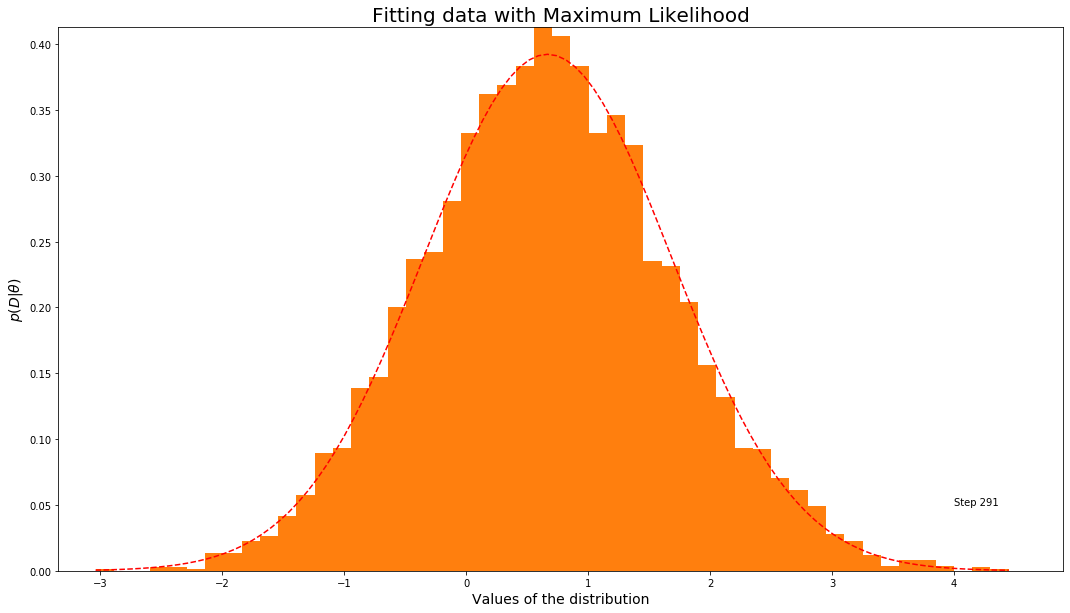

In [7]:
f, ax = plt.subplots(figsize=(18,10))
Artists = namedtuple("Artists",("prob","step"))
artists = Artists(plt.plot([], [], "r--",animated=True)[0], 
                  ax.text(x=0.9*vr[-1].numpy(), y = 0.05, s=""))

init = partial(init_fig, f=f, ax=ax, artists=artists, data=x)
update = partial(update_artists, artists=artists, value_range=vr)
frame = partial(frame_iter, update_list=ul, prob_values=pv)

ani = animation.FuncAnimation(fig=f, 
                              func=update, 
                              frames = frame,
                              init_func = init)

ani.save(
  filename='myvideo_new2.mp4'
)

Now let's plot the learning curves:

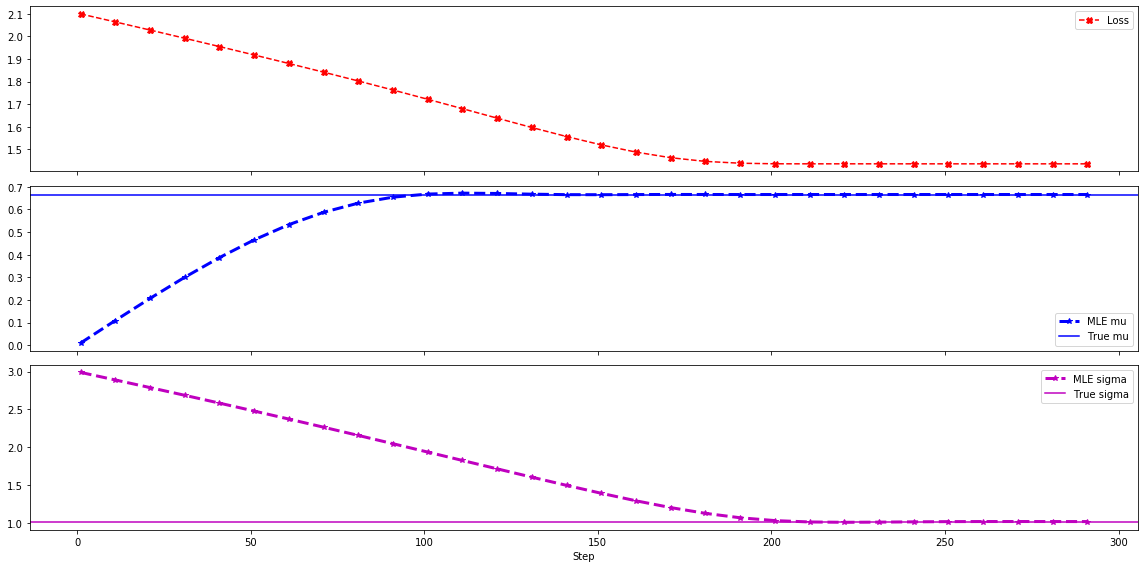

In [13]:
plot_curves(ul, x, [mu,sigma])

## MLE for Poisson distribution
The second example tries to estimate the parameter from data generated with a discrete distribution like Poisson.

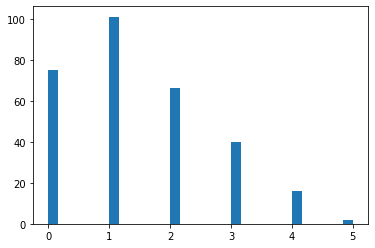

In [14]:
fake_samples = tf.random.poisson([300], 1.4)
fake_samples = tf.cast(tf.math.ceil(fake_samples), tf.float32)

In [15]:
# The model is a probability distribution
rate = tf.Variable([5.], name="rate") # Give the parameter an initial value
model = tfd.Poisson(rate=rate)

In [16]:
optimizer = tf.optimizers.Adam(0.01)
ulp, pvp, vrp = mle_run(fake_samples, model, [rate], optimizer, steps=800, verbose=True)

Step: 1, initial loss: 3.3020403385162354, rate: [4.9900002]
Step: 11, initial loss: 3.23081374168396, rate: [4.8900356]
Step: 21, initial loss: 3.1602823734283447, rate: [4.790227]
Step: 31, initial loss: 3.090550184249878, rate: [4.690694]
Step: 41, initial loss: 3.0217032432556152, rate: [4.5915265]
Step: 51, initial loss: 2.9538094997406006, rate: [4.4927883]
Step: 61, initial loss: 2.88692045211792, rate: [4.394528]
Step: 71, initial loss: 2.821084976196289, rate: [4.2967854]
Step: 81, initial loss: 2.756347417831421, rate: [4.1995964]
Step: 91, initial loss: 2.692753791809082, rate: [4.1029973]
Step: 101, initial loss: 2.6303486824035645, rate: [4.0070257]
Step: 111, initial loss: 2.5691795349121094, rate: [3.9117212]
Step: 121, initial loss: 2.5092968940734863, rate: [3.817127]
Step: 131, initial loss: 2.450749397277832, rate: [3.723288]
Step: 141, initial loss: 2.393590211868286, rate: [3.6302533]
Step: 151, initial loss: 2.3378727436065674, rate: [3.5380754]
Step: 161, initial

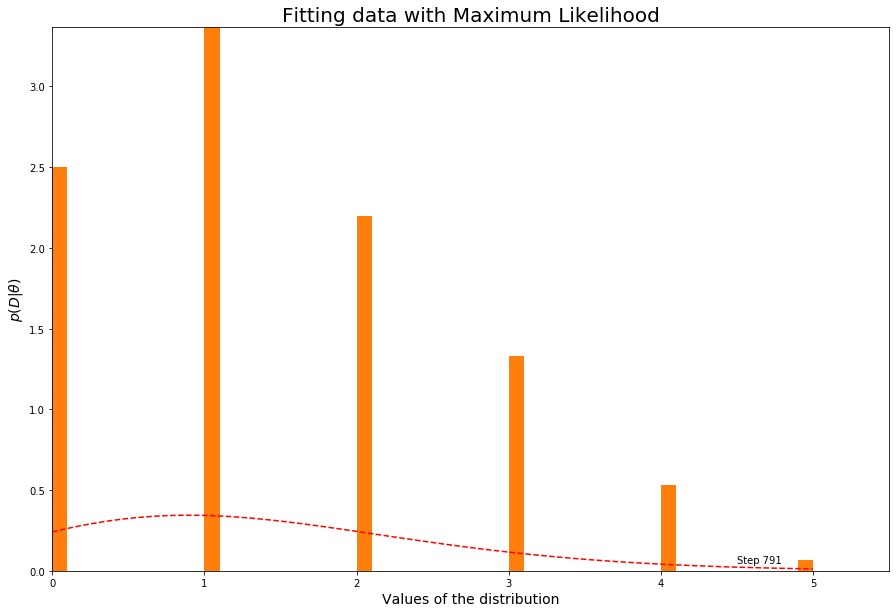

In [17]:
f, ax = plt.subplots(figsize=(15,10))
Artists = namedtuple("Artists",("prob","step"))
artists = Artists(plt.plot([], [], "r--",animated=True)[0], 
                  ax.text(x=0.9*vrp[-1].numpy(), y = 0.05, s=""))

init = partial(init_fig, f=f, ax=ax, artists=artists, data=fake_samples)
update = partial(update_artists, artists=artists, value_range=vrp)
frame = partial(frame_iter, update_list=ulp, prob_values=pvp)

ani = animation.FuncAnimation(fig=f, 
                              func=update, 
                              frames = frame,
                              init_func = init)

ani.save(
  filename='myvideo_poisson2.mp4'
)

And we plot the learning curves:

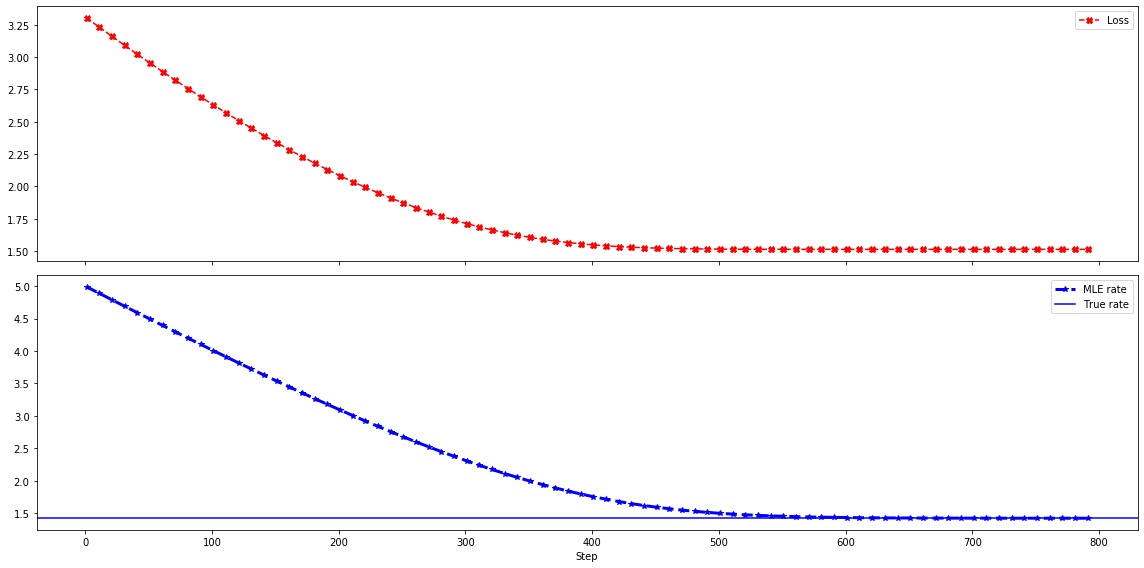

In [18]:
plot_curves(ulp, fake_samples, [rate])